### Emittance evolution over many runs of the same study

- Plot the emittance evolution in x and y after sixtracklib tracking along with the theoretical expexted rate.
- The theoretical expected rate is computed from the functions in '../utils/my_functions.py' after defining the machine and the beam parameters in the present script.
- The simulation for each set of parameters is repeated multiple times. The mean and the standard deviation of the emittance values are computed over all runs (part 3) for each turn.
- The script can be used for amplitude noise AN and/or phase noise PN.
- The normalised emittance is used here.

In [2]:
import os
import sys
sys.path.append('../../utils/')
from cmptTheoreticalEmitGrowth import *
from bunchLengthConversions import *
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#### Plotting paramerters

In [3]:
params = {'legend.fontsize': 20,
          'figure.figsize': (9.5, 8.5),
          'axes.labelsize': 27,
          'axes.titlesize': 23,
          'xtick.labelsize': 27,
          'ytick.labelsize': 27,
          'image.cmap': 'jet',
          'lines.linewidth': 1,
          'lines.markersize': 5,
          'font.family': 'sans-serif'}

plt.rc('text', usetex=False)
plt.rc('font', family='serif')
plt.rcParams.update(params)

#### 1) Load the data
a) Give the paths to the data in /afs/.

b) Load the values of the transverse emittance in a dictionary.

In [25]:
n_runs = 3 # number of runs that the simulation was repeated
turns = 1e5
circumference  = 6911.5623 # [m]
f_rev  = 299792458/circumference  # [Hz] The revolution frequency of the machine 
f_rev = 43375.86 # [Hz]
turns_list = np.arange(0,turns)
time = turns_list/f_rev # [s], type: list
globalCCscheme = True
flag = True # flag to remove the first 200 elements (during the ramping up)

In [12]:
my_start = 400.0
my_stop = 1.6e4
my_step = 800.0
my_variables = list(np.arange(my_start, my_stop, my_step))
# my_variables = ['']
my_variables.insert(0, 0.0)
print(my_variables)

[0.0, 400.0, 1200.0, 2000.0, 2800.0, 3600.0, 4400.0, 5200.0, 6000.0, 6800.0, 7600.0, 8400.0, 9200.0, 10000.0, 10800.0, 11600.0, 12400.0, 13200.0, 14000.0, 14800.0, 15600.0]


In [19]:
path_to_data = '/afs/cern.ch/work/n/natriant/private/tbt_from_GPUs/'
study_name = 'globalCC2deg90_1MV_realNoise_PNCoast3PartC_1e5turns_Nb20k_nob3b5b7_QpyQpx0'
noise_type = 'PN' # 'PN', 'AN', 'BOTH'

In [20]:
# phase noise
ex_dict = {} # type: dictionary
ey_dict = {}

for var in my_variables:
    for run in range(n_runs):
        print(var, run)
        temp_name = f'{var}_run{run}'
        # A. load the turn by turn data in a dictionary
        temp_dict = pickle.load( open(path_to_data+study_name+f'/ayy{var}/tbt_{run}.pkl', "rb" ) )
        # B. Create a different list for each run and save the emittance values
        ex_dict[temp_name] = temp_dict['neps_x'] # ΑΝ
        ey_dict[temp_name] = temp_dict['neps_y']
        #print(len(ex_dict[temp_name]))
        #plt.plot(ey_dict[temp_name]/ey_dict[temp_name][0])

0.0 0
0.0 1
0.0 2
400.0 0
400.0 1
400.0 2
1200.0 0
1200.0 1
1200.0 2
2000.0 0
2000.0 1
2000.0 2
2800.0 0
2800.0 1
2800.0 2
3600.0 0
3600.0 1
3600.0 2
4400.0 0
4400.0 1
4400.0 2
5200.0 0
5200.0 1
5200.0 2
6000.0 0
6000.0 1
6000.0 2
6800.0 0
6800.0 1
6800.0 2
7600.0 0
7600.0 1
7600.0 2
8400.0 0
8400.0 1
8400.0 2
9200.0 0
9200.0 1
9200.0 2
10000.0 0
10000.0 1
10000.0 2
10800.0 0
10800.0 1
10800.0 2
11600.0 0
11600.0 1
11600.0 2
12400.0 0
12400.0 1
12400.0 2
13200.0 0
13200.0 1
13200.0 2
14000.0 0
14000.0 1
14000.0 2
14800.0 0
14800.0 1
14800.0 2
15600.0 0
15600.0 1
15600.0 2


In [29]:
flag = False

In [21]:
# if global CC scheme remove the first 200 turns (ramping up)
if flag:
    if globalCCscheme:
        for var in my_variables:
            for run in range(n_runs):
                temp_name = f'{var}_run{run}'
                ex_dict[temp_name] = ex_dict[temp_name][200:]
                ey_dict[temp_name] = ey_dict[temp_name][200:]
        time = time[200:]
        flag = False # switch the flag to False so it no more elemnets are removed.

### Plot example case

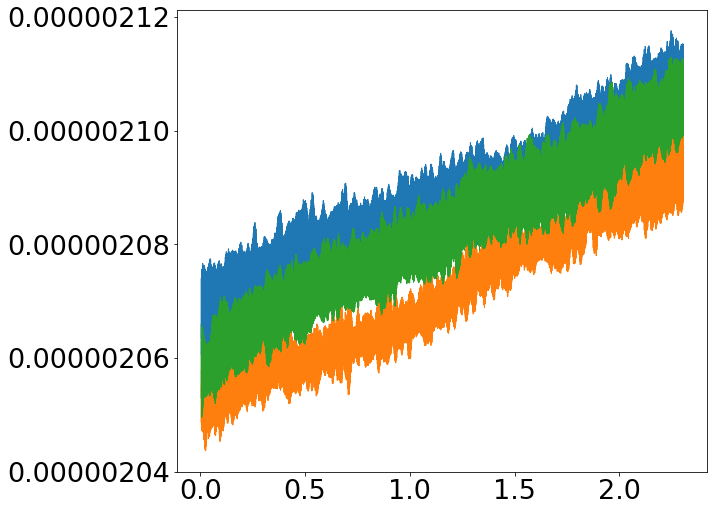

In [32]:
var = my_variables[0]
for run in range(n_runs):
    temp_name = f'{var}_run{run}'
    plt.plot(time, ey_dict[temp_name])

#### 2) Calculate the emittance growth for each run rate via a linear fit
- Polynomial fit. The degree of the fitting polynomial is 1. 
- V plane only and phase noise only, if otherwise choose the apropriate dictionary from step 1.

    - ex_dict_pn[temp_name] 
    - ey_dict_pn[temp_name]


In [33]:
m_dict = {} # slope of the fit
b_dict = {} # offset
err_dict = {} # error of the gradient of the fit slope
for var in my_variables:
    m_dict[f'{var}'], b_dict[f'{var}'], err_dict[f'{var}'] = [], [], []
    for run in range(n_runs):
        temp_name = f'{var}_run{run}'
        # linear fit
        [m, b], cov = np.polyfit(time, ey_dict[temp_name], 1, cov=True)
        # compute the error of the gradient of the fit slope
        err= np.sqrt(np.diag(cov))
        m_dict[f'{var}'].append(m) # len(m_dict[f'{var}']) = n_runs
        b_dict[f'{var}'].append(b)
        err_dict[f'{var}'].append(err[0])

In [36]:
m_dict[f'{my_variables[15]}']

[1.7084370961622444e-08, 1.6102937499586357e-08, 2.142314114636074e-08]

In [37]:
'''
ey_std_init = ey_std
ey_mean_init = ey_mean
'''

'\ney_std_init = ey_std\ney_mean_init = ey_mean\n'

In [38]:
data = {}
for var in my_variables:
    data[f'ayy{var}'] =[m_dict[f'{var}'], b_dict[f'{var}'], err_dict[f'{var}']]
df = pd.DataFrame(data, index=['m','b','err'])

filename = f'deyRates_{study_name}.pkl'
if not os.path.exists(filename):
    df.to_pickle(filename)

In [39]:
df

,ayy0.0,ayy400.0,ayy1200.0,ayy2000.0,ayy2800.0,ayy3600.0,ayy4400.0,ayy5200.0,ayy6000.0,ayy6800.0,...,ayy8400.0,ayy9200.0,ayy10000.0,ayy10800.0,ayy11600.0,ayy12400.0,ayy13200.0,ayy14000.0,ayy14800.0,ayy15600.0
m,"[1.6651345903953858e-08, 1.8344365568443774e-0...","[1.9332022549881485e-08, 2.045906067549651e-08...","[1.538861311621034e-08, 1.552632754407844e-08,...","[1.7048728588428725e-08, 1.870490517779558e-08...","[1.6155899589906792e-08, 1.8175299124391277e-0...","[1.4869728454416958e-08, 1.6209283409291386e-0...","[1.7632518671980514e-08, 1.4785184630869286e-0...","[1.8253385999043315e-08, 1.4775033575820563e-0...","[1.4438325410554038e-08, 1.8411664167806027e-0...","[1.5798930566112087e-08, 1.675441081772341e-08...",...,"[1.798625734971711e-08, 1.7304898666036706e-08...","[1.7629075965526397e-08, 1.8619092931803057e-0...","[1.4799995806795514e-08, 1.806718719683026e-08...","[1.886845317011165e-08, 1.5635822125870844e-08...","[1.7084370961622444e-08, 1.6102937499586357e-0...","[1.4770795626834908e-08, 1.594717141046578e-08...","[1.573064762589352e-08, 1.8467173788502383e-08...","[2.0881362483532258e-08, 1.800749975358654e-08...","[1.6433960902102937e-08, 1.616651823222866e-08...","[1.5446617161245327e-08, 1.8728555169303128e-0..."
b,"[2.0682871697947466e-06, 2.0504867188073024e-0...","[2.055111205707103e-06, 2.0524630141653685e-06...","[2.0781763197236063e-06, 2.0513684769222422e-0...","[2.0635016542328727e-06, 2.042805183605811e-06...","[2.077998916815779e-06, 2.0414757503946015e-06...","[2.091010358667956e-06, 2.0795967749021853e-06...","[2.0657710735688095e-06, 2.0847706856098754e-0...","[2.0670187824137443e-06, 2.070945478615871e-06...","[2.0686427828235968e-06, 2.0997565561720753e-0...","[2.028672532350703e-06, 2.0699275142622875e-06...",...,"[2.0807414723901725e-06, 2.0181267761410555e-0...","[2.0595400516719665e-06, 2.0845421266491612e-0...","[2.053155903048645e-06, 2.050787563529422e-06,...","[2.0287484223867314e-06, 2.085451815012359e-06...","[2.054478756777432e-06, 2.0743339760286066e-06...","[2.042626844399588e-06, 2.0695449575891044e-06...","[2.07276179549496e-06, 2.0436560944919332e-06,...","[2.0418632134723904e-06, 2.062751567096674e-06...","[2.0584656450440598e-06, 2.058565452945807e-06...","[2.0286258737924295e-06, 2.0623738683682103e-0..."
err,"[1.8122823337818012e-11, 1.3615929901910319e-1...","[1.887698930235757e-11, 1.9716305715489404e-11...","[1.756563618873939e-11, 1.3736008562211237e-11...","[1.7992018357631608e-11, 1.637740547135515e-11...","[1.8479256357824685e-11, 1.878683048458267e-11...","[1.7968912874722714e-11, 1.8787354127808114e-1...","[1.875928470164833e-11, 1.7900300558258243e-11...","[1.9021315305387165e-11, 1.635772578009142e-11...","[1.7299043624678722e-11, 1.7864235396083758e-1...","[2.0127344398502055e-11, 1.725235529779505e-11...",...,"[1.799201090181467e-11, 1.7902885562110943e-11...","[1.987845730940855e-11, 1.6608450545099902e-11...","[1.6926694863693458e-11, 1.7771124656019492e-1...","[1.818679261446185e-11, 1.801905524561322e-11,...","[1.8213031034665232e-11, 1.6929551273893132e-1...","[1.6258797417581318e-11, 1.7873700066086773e-1...","[1.7670988318088334e-11, 1.6884381540814604e-1...","[1.7687789421112983e-11, 1.678427749340302e-11...","[1.8452924146540192e-11, 1.730157669095654e-11...","[1.6249140896891003e-11, 1.79883065888858e-11,..."


### Plot emittance growth for one of the variables

['ayy0.0', 'ayy400.0', 'ayy1200.0', 'ayy2000.0', 'ayy2800.0', 'ayy3600.0', 'ayy4400.0', 'ayy5200.0', 'ayy6000.0', 'ayy6800.0', 'ayy7600.0', 'ayy8400.0', 'ayy9200.0', 'ayy10000.0', 'ayy10800.0', 'ayy11600.0', 'ayy12400.0', 'ayy13200.0', 'ayy14000.0', 'ayy14800.0', 'ayy15600.0']


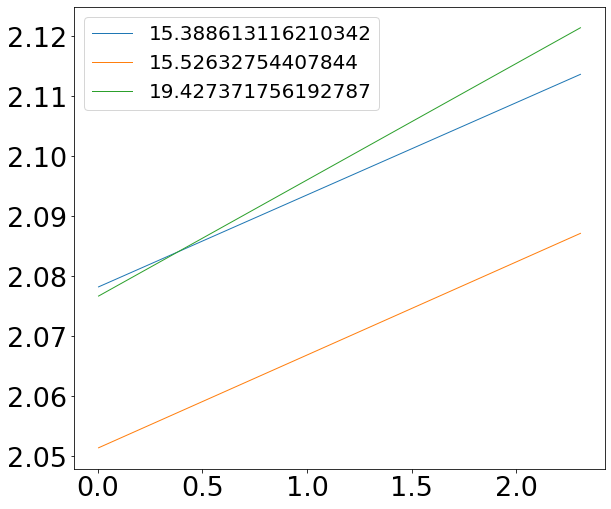

In [41]:
studies_list = list(df.keys())
print(studies_list)
study = studies_list[2] # choose study


for run in np.arange(len(df[study]['m'])):
    plt.plot(time, (df[study]['m'][run]*time+df[study]['b'][run])*1e6, label=df[study]['m'][run]*1e9)
# linear fit on the emittance values obtained from the simulation averaged over turns
#plt.plot(time, (m*time+b)*1e6, c = 'k', label='dey/dt={0:.2f}'.format(m*1e9)+'$\pm$'+'{0:.2f} nm/s'.format(err[0]*1e9), linewidth = 2)
plt.legend()

#plt.plot(time, df[])

### 9) Compute the theoretically expected rate
- Define the machine and beam parameters
- Define the levels of noise for A
- Compute the expected rate from the functions in '../utils/my_functions.py'
- Define the colors according to the type of the study

In [14]:
# Machine parameters
betay = 73 # 73 m at CC2, 76 m at CC1
Vcc = 1e6 # V
frev = 43.45e3 # Hz
Eb = 270e9 # eV
beta_0 = 0.999999
gamma_0 = 287.7
sigma_z = 0.139 # m
f_CC = 400.789e6 # CC frequency in Hz
clight = 299792458 # m/s
A_phase = 1e-8 # rms kick in the simulation of the phase noise
A_amplitude = 0 # rms kick in the simulation of the amplitude noise
scale_factor = Eb/Vcc # scaling factor to rms noise, σ
# Compute the PSD in rad^2/Hz and V^2/Hz
PSD_phi = (A_phase * scale_factor)**2/frev # rad^2/Hz
PSD_phi = 1.42e-10
#PSD_phi = 1.4e-10
PSD_A = 3.99e-11 #(A_amplitude * scale_factor)**2/frev # V^2/Hz
print(PSD_phi, PSD_A)

1.42e-10 3.99e-11


In [1]:
# Compute the correction factor due to the bunch length
sigma_phi = bunch_length_m_to_rad(sigma_z, clight, f_CC)
CDeltaphi = cmpt_bunch_length_correction_factor(sigma_phi, 'PN')
CDeltaA = cmpt_bunch_length_correction_factor(sigma_phi, 'AN')
print('CDeltaPhi = {}, CDeltaA = {}'.format(CDeltaphi, CDeltaA))

if noise_type == 'PN':
    expected_growth = emit_growth_phase_noise(betay, Vcc, frev, Eb, CDeltaphi, PSD_phi)*beta_0*gamma_0 # m/s
    my_color = 'C0'
    fill_bewtween_color = 'lightblue'
elif noise_type == 'AN':
    expected_growth = emit_growth_amplitude_noise(betay, Vcc, frev, Eb, CDeltaA, PSD_A)*beta_0*gamma_0 # m/s
    my_color = 'C1'
    fill_bewtween_color = 'moccasin'
else:
    my_color = 'C2'
    expected_growth_1 = emit_growth_phase_noise(betay, Vcc, frev, Eb, CDeltaphi, PSD_phi)*beta_0*gamma_0 # m/s
    expected_growth_2 = emit_growth_amplitude_noise(betay, Vcc, frev, Eb, CDeltaA, PSD_A)*beta_0*gamma_0 # m/s
    expected_growth = expected_growth_1 + expected_growth_2

print('expected growth = {} nm/s'.format(expected_growth*1e9))

NameError: name 'bunch_length_m_to_rad' is not defined

#### 8) Plot fill between

#### A) y axis: emittance values

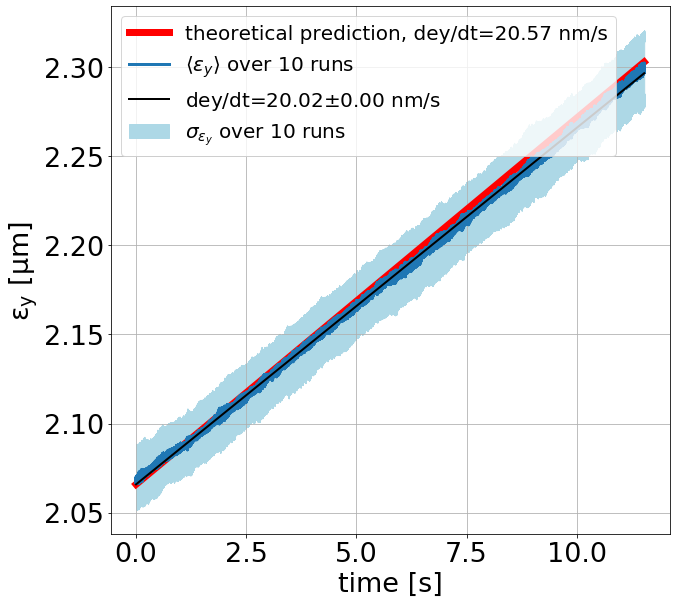

In [16]:
# std over all runs
ey_std = ey_std[200:]
if noise_type == 'BOTH': # just for customizing purposes
    plt.fill_between(time, np.array(ey_mean)*1e6 - np.array(ey_std)*1e6, np.array(ey_mean)*1e6 + np.array(ey_std)*1e6, facecolor=my_color, alpha=0.2,  label=r'$\sigma_{\epsilon_y}$'+ ' over {} runs'.format(n_runs))
else:
    plt.fill_between(time, np.array(ey_mean )*1e6 - np.array(ey_std)*1e6, np.array(ey_mean)*1e6 + np.array(ey_std)*1e6, color=fill_bewtween_color, label=r'$\sigma_{\epsilon_y}$'+ ' over {} runs'.format(n_runs))
# expected slope from analytical calculations
plt.plot(time, (expected_growth*time+b)*1e6, c='r', linewidth=7, label='theoretical prediction, dey/dt={:.2f} nm/s'.format(expected_growth*1e9))

# emittance values obtained from the simulation averaged over turns
plt.plot(time, np.array(ey_mean)*1e6, c=my_color, linewidth=3, label=r'$\langle \epsilon_y \rangle $'+' over {} runs'.format(n_runs))

# linear fit on the emittance values obtained from the simulation averaged over turns
plt.plot(time, (m*time+b)*1e6, c = 'k', label='dey/dt={0:.2f}'.format(m*1e9)+'$\pm$'+'{0:.2f} nm/s'.format(err[0]*1e9), linewidth = 2)



plt.xlabel('time [s]')
plt.ylabel(r'$\mathrm{\epsilon_y \ [\mu m]}$')
plt.legend(loc=0)
plt.grid()
#plt.ylim(1.98, 2.10)
#plt.ylim(1.98, 2.6)

plt.tight_layout()
savefig = False
if savefig:
    plt.savefig('V_localCC_emittance_growth_rate_270GeV_SPS_{}Apn3e-8_Aan5e-9_VRF5_088MV_1e5Nb_1e5turns_mean{}run_fill_between.png'.format(noise_type, n_runs))

#### B) y axis: emittance values after substracting the initial emittance

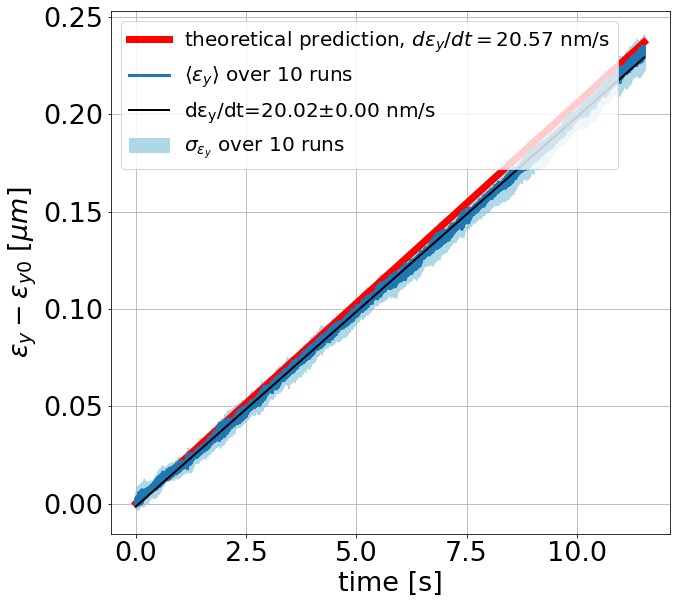

In [17]:
initial_std = ey_std_init[200] #0
initial_mean_emittance = ey_mean_init[200] #0

# std over all runs
if noise_type == 'BOTH': # just for customizing purposes
    plt.fill_between(time, np.array(ey_mean-initial_mean_emittance )*1e6 - np.array(ey_std-initial_std)*1e6, np.array(ey_mean-initial_mean_emittance)*1e6 + np.array(ey_std-initial_std)*1e6, facecolor=my_color, alpha=0.2, label=r'$\sigma_{\epsilon_y}$'+ ' over {} runs'.format(n_runs), zorder=50)
else:
    plt.fill_between(time, np.array(ey_mean-initial_mean_emittance )*1e6 - np.array(ey_std-initial_std)*1e6, np.array(ey_mean-initial_mean_emittance)*1e6 + np.array(ey_std-initial_std)*1e6, color=fill_bewtween_color, label=r'$\sigma_{\epsilon_y}$'+ ' over {} runs'.format(n_runs))

# expected slope from analytical calculations
plt.plot(time, (expected_growth*time)*1e6, c='r', linewidth=7, label='theoretical prediction, '+r'$d\epsilon_y/dt=$'+'{:.2f} nm/s'.format(expected_growth*1e9))

# emittance values obtained from the simulation averaged over turns
plt.plot(time, np.array(ey_mean-initial_mean_emittance)*1e6, c=my_color, linewidth=3, label=r'$\langle \epsilon_y \rangle $'+' over {} runs'.format(n_runs))


# linear fit on the emittance values obtained from the simulation averaged over turns
#plt.plot(time, (m_pn*time)*1e6, c = 'k', label='dey/dt={0:.2f}'.format(m_pn*1e9)+'$\pm$'+'{0:.2f} nm/s'.format(err_pn[0]*1e9), linewidth = 2)
plt.plot(time, (m*time+b-initial_mean_emittance)*1e6, c = 'k', label=r'$\mathrm{d\epsilon_y/dt}$'+'={0:.2f}'.format(m*1e9)+'$\pm$'+'{0:.2f} nm/s'.format(err[0]*1e9), linewidth = 2)

plt.xlabel('time [s]')
plt.ylabel(r'$\epsilon_y - \epsilon_{y0} \ [\mu m]$')
plt.legend(loc=0)
plt.grid()
#plt.ylim(0, 0.08)
#plt.ylim(0, 0.6)

plt.tight_layout()
savefig = True
if savefig:
    plt.savefig('V_local_emit_growth_rate_substract_initial_emittance_270GeV_SPS_{}_PN1e-8_VRF2_37MV_1e5Nb_1e5turns_mean{}run_fill_between_v2.png'.format(noise_type, n_runs))

### The uncertainty of the growth rate is the std of the growth rates over all runs, as obtained from Method 2

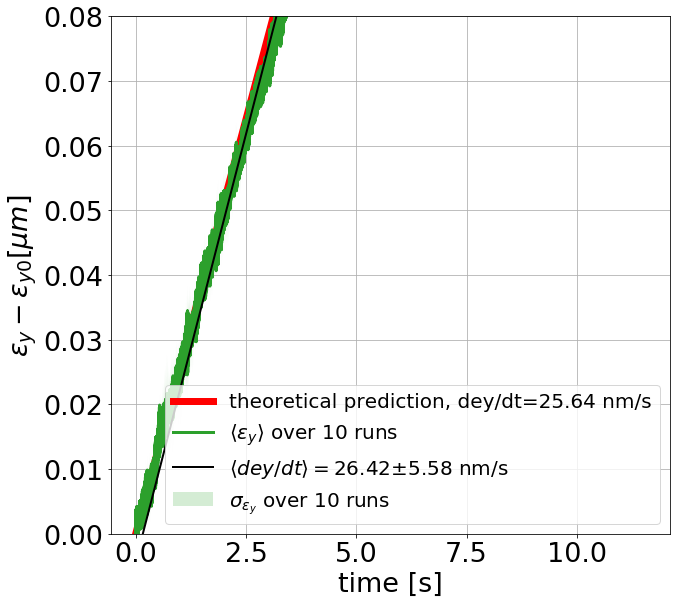

In [45]:
initial_std = ey_std[0]
initial_mean_emittance = ey_mean[0]
# std over all runs
if noise_type == 'BOTH': # just for customizing purposes
    plt.fill_between(time, np.array(ey_mean-initial_mean_emittance )*1e6 - np.array(ey_std-initial_std)*1e6, np.array(ey_mean-initial_mean_emittance)*1e6 + np.array(ey_std-initial_std)*1e6, facecolor=my_color, alpha=0.2, label=r'$\sigma_{\epsilon_y}$'+ ' over {} runs'.format(n_runs))
else:
    plt.fill_between(time, np.array(ey_mean-initial_mean_emittance )*1e6 - np.array(ey_std-initial_std)*1e6, np.array(ey_mean-initial_mean_emittance)*1e6 + np.array(ey_std-initial_std)*1e6, color=fill_bewtween_color, label=r'$\sigma_{\epsilon_y}$'+ ' over {} runs'.format(n_runs))

# expected slope from analytical calculations
plt.plot(time, (expected_growth*time)*1e6, c='r', linewidth=7, label='theoretical prediction, '+r'$d\epsilon ey/dt={:.2f} nm/s$'.format(expected_growth*1e9))

# emittance values obtained from the simulation averaged over turns
plt.plot(time, np.array(ey_mean-initial_mean_emittance)*1e6, c=my_color, linewidth=3, label=r'$\langle \epsilon_y \rangle $'+' over {} runs'.format(n_runs))

# linear fit on the emittance values obtained from the simulation averaged over turns
#plt.plot(time, (m_pn*time)*1e6, c = 'k', label='dey/dt={0:.2f}'.format(m_pn*1e9)+'$\pm$'+'{0:.2f} nm/s'.format(err_pn[0]*1e9), linewidth = 2)
plt.plot(time, (m*time+b-initial_mean_emittance)*1e6, c = 'k', label=r'$\langle dey/dt \rangle ={0:.2f}$'.format(m*1e9)+'$\pm$'+'{0:.2f} nm/s'.format(5.58), linewidth = 2)

plt.xlabel('time [s]')
plt.ylabel(r'$\epsilon_y - \epsilon_{y0} \m [\mu m]$')
plt.legend(loc=0)
plt.grid()
#plt.ylim(0, 0.35)
plt.ylim(0, 0.08)

plt.tight_layout()
savefig = False
if savefig:
    plt.savefig('V_emit_growth_rate_substract_initial_emittance_270GeV_SPS_{}_PN1e-8_VRF5_088MV_20kNb_{}turns_mean{}run_fill_between_v2.png'.format(noise_type, turns, n_runs))